# Stereo 

A script for implementing stereo algorithms 1, 2, and 3 from the lecture slides

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm

In [2]:
# RGB to gray
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

### Stereo algorithm1

In [3]:
def stereo1(img1, img2, dispRange):
    # Load in both images, assumed to be RGBA 8bit per channel images    
    h, w = img1.shape  # assume that both images are same size   
    
    left = img1.copy()
    right = img2.copy()
    
    # Depth (or disparity) map
    dispMap = np.zeros((h, w), np.int8)
      
    for y in range(h):      
        print(".", end="", flush=True)  # let the user know that something is happening (slowly!)
        
        for x in range(w):
            best_offset = 0
            prev_d = None
            
            for offset in range(-dispRange, dispRange+1):               
                maxc = max(0, x + offset)
                maxc = min(maxc, w-1)
                
                d = abs(int(left[y, x]) - int(right[y, maxc]))              
                            
                
                # if this value is smaller than the previous ssd at this block
                # then it's theoretically a closer match. Store this value against
                # this block..
                if prev_d == None or d < prev_d:
                    prev_d = d
                    best_offset = abs(offset)
                            
            # set depth output for this x,y location to the best match
            dispMap[y, x] = best_offset
                                
    return dispMap

### Stereo algorithm2

In [4]:
def map_value(img):
    #print(np.min(img))
    return (((img - np.min(img)) / (np.max(img) - np.min(img))) * 255).astype(np.uint8)

def metric_SSD(block_l, block_r):
    return np.sum(np.square(block_l - block_r))


def stereo2(img1, img2, dispRange, windowSize):
    pad_size = windowSize // 2
    img_left = np.pad(img1, ((pad_size, pad_size), (pad_size, pad_size)), 'constant', constant_values=((0, 0), (0, 0)))
    img_right = np.pad(img2, ((pad_size, pad_size), (pad_size, pad_size)), 'constant', constant_values=((0, 0), (0, 0)))
    result = np.empty([img1.shape[0], img1.shape[1]])
    print(img_left.shape, img_right.shape)
    for i in range(0, img1.shape[0]):
        print(".", end="", flush=True)
        for j in range(0, img1.shape[1]):
            # print "j: ", j
            filter = img_left[i:i+windowSize, j:j+windowSize]
            start = np.amax([0, j-dispRange])
            best_SSD = 99999999
            best_x = start
            end = np.amin([img1.shape[1], j+dispRange])

            # calcuate SSD for dispRange
            for k in range(start, end):
                SSD = metric_SSD(filter, img_right[i:i + windowSize, k:k + windowSize])
                if SSD < best_SSD:
                    best_SSD = SSD
                    best_x = k
            result[i][j] = np.absolute(j - best_x)

    return map_value(result)

### Stereo algorithm3

In [5]:
def stereo3(img1, img2, dispRange, windowSize, lamda):
    left_img = img1.copy()
    right_img = img2.copy()

    x,y=left_img.shape
    v,w=right_img.shape
    #print "left image dimension",x,y
    #print "right image dimension",v,w

    DisparityMatrix_left=np.zeros(left_img.shape, np.uint8)
    DisparityMatrix_right=np.zeros(right_img.shape, np.uint8)
    #DisparityMatrix_left.astype(int)
    #DisparityMatrix_right.astype(int)

    #Disparity Computation for Left Image

    OcclusionCost = 20 #(You can adjust this, depending on how much threshold you want to give for noise)

    #For Dynamic Programming you have build a cost matrix. Its dimension will be numcols x numcols
    for all_rows in range (0,x):
        #print all_rows
        CostMatrix=np.zeros((y,y))

        DirectionMatrix = np.zeros((y,y))  #(This is important in Dynamic Programming. You need to know which direction you need traverse)

        #We first populate the first row and column values of Cost Matrix

        for i in range(0,y):
            CostMatrix[i,0] = i*OcclusionCost
            CostMatrix[0,i] = i*OcclusionCost

            #print np.abs((left_img[all_rows,0]-right_img[all_rows,0]))

        for i in range(0,y):
            for j in range (0,y):
                min1=CostMatrix[i-1,j-1]+np.abs((int(left_img[all_rows,i])-int(right_img[all_rows,j])))
                min2=CostMatrix[i-1,j]+OcclusionCost
                min3=CostMatrix[i,j-1]+OcclusionCost
                cmin=np.min((min1,min2,min3))

                CostMatrix[i,j]=cmin
                if min1==cmin:
                    DirectionMatrix[i,j]=1
                if min2==cmin:
                    DirectionMatrix[i,j]=2
                if min3==cmin:
                    DirectionMatrix[i,j]=3

            #print DirectionMatrix
            # Now, its time to populate the whole Cost Matrix and DirectionMatrix

            # Use the pseudocode from "A Maximum likelihood Stereo Algorithm" paper given as reference
            p=y-1
            q=y-1

            #print q
            #print p

        while ((p!=0) and (q!=0)):
            #print "Values for direction matrix"
            #print(DirectionMatrix[p,q])
            if DirectionMatrix[p,q]==1:
                #print("inside 1")
                DisparityMatrix_left[all_rows,p]=np.abs(p-q)
                DisparityMatrix_right[all_rows,q]=np.abs(p-q)
                p=p-1
                q=q-1

            elif DirectionMatrix[p,q]==2:
                #print("inside 2")
                p=p-1
                # DisparityMatrix_left[all_rows,p]=np.abs(p-q)


            elif DirectionMatrix[p,q]==3:
                #print("inside 3")
                q=q-1
                # DisparityMatrix_right[all_rows,q]=np.abs(p-q)
                
    return DisparityMatrix_left, DisparityMatrix_right

### MSE

In [6]:
# calculate mse
def mse(leftDisp,rightDisp, leftGT, rightGT):
    leftGroundTruthImg = leftGT.copy()
    rightGroundTruthImg = rightGT.copy()
    
    rows = leftGroundTruthImg.shape[0]
    cols = leftGroundTruthImg.shape[1]
    
    mseValueLeft=0 
    mseValueRight=0 
    
    for i in range (0,rows):
        for j in range(0,cols):
            if(leftDisp[i][j]!=0):
               mseValueLeft += np.square(int(rightGroundTruthImg[i][j])-int(leftDisp[i][j]))
            if(rightDisp[i][j]!=0):
               mseValueRight += np.square(int(rightGroundTruthImg[i][j])-int(rightDisp[i][j]))
    
    
    mseValueLeft = mseValueLeft/(rows*cols)
    mseValueRight = mseValueRight/(rows*cols)
    
    print("MSE_Left Value : "+str(mseValueLeft))
    print("MSE_Right Value : "+str(mseValueRight))

### MSE for Tsukuba

In [7]:
# calculate mse
def mse_tsukuba(leftDisp, leftGT):
    leftGroundTruthImg = leftGT.copy()
    #rightGroundTruthImg = rightGT.copy()
    
    rows = leftGroundTruthImg.shape[0]
    cols = leftGroundTruthImg.shape[1]
    
    mseValueLeft=0 
    #mseValueRight=0 
    
    for i in range (0,rows):
        for j in range(0,cols):
            if(leftDisp[i][j]!=0):
               mseValueLeft += np.square(int(leftGroundTruthImg[i][j])-int(leftDisp[i][j]))
            #if(rightDisp[i][j]!=0):
            #   mseValueRight += np.square(int(rightGroundTruthImg[i][j])-int(rightDisp[i][j]))
    
    
    mseValueLeft = mseValueLeft/(rows*cols)
    #mseValueRight = mseValueRight/(rows*cols)
    
    print("MSE_Left Value : "+str(mseValueLeft))
    #print("MSE_Right Value : "+str(mseValueRight))

## Sawtooth

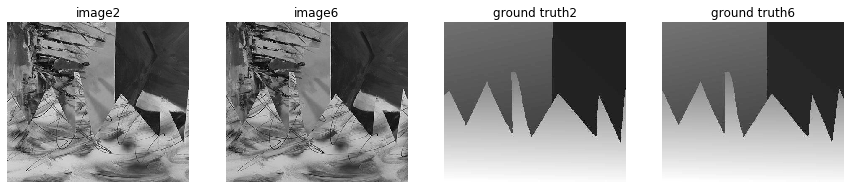

In [8]:
sawtooth2 = "sawtooth/im2.jpg"
sawtooth6 = "sawtooth/im6.jpg"

sawtooth2GT = 'sawtooth/disp2.jpg'
sawtooth6GT = 'sawtooth/disp6.jpg'

# load img2, img6
img2 = rgb2gray(plt.imread(sawtooth2)).astype(np.uint8)
img6 = rgb2gray(plt.imread(sawtooth6)).astype(np.uint8)

# load ground truth
gt2 = plt.imread(sawtooth2GT).astype(np.uint8)
gt6 = plt.imread(sawtooth6GT).astype(np.uint8)

imgs = [img2, img6, gt2, gt6]
titles = ['image2', 'image6', 'ground truth2', 'ground truth6']

# plot images
f, axes = plt.subplots(1, 4, figsize=(15, 3))
for idx, img in enumerate(imgs):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(titles[idx])

### Stereo 1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................MSE_Left Value : 6292.793930390492
MSE_Right Value : 6380.954499151104


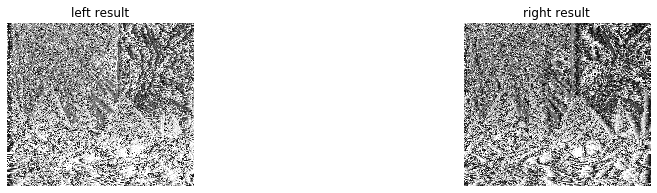

In [9]:
dispRange = 15
st1_left = stereo1(img2, img6, dispRange)
st1_right = stereo1(img6, img2, dispRange)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st1_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st1_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse(st1_left, st1_right, gt2, gt6)

### Stereo 2

(386, 440) (386, 440)
............................................................................................................................................................................................................................................................................................................................................................................................(386, 440) (386, 440)
............................................................................................................................................................................................................................................................................................................................................................................................MSE_Left Value : 1035.0385035168567
MSE_Right Value : 1088.5749029832646


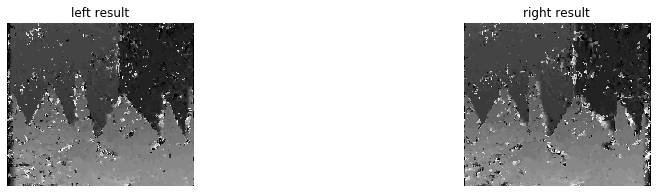

In [10]:
windowSize = 7
dispRange = 30

st2_left = stereo2(img2, img6, dispRange, windowSize)
st2_right = stereo2(img6, img2, dispRange, windowSize)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st2_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st2_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse(st2_left, st2_right, gt2, gt6)

In [11]:
mse(st2_right, st2_left, gt2, gt6)

MSE_Left Value : 1088.5749029832646
MSE_Right Value : 1035.0385035168567


### Stereo 3

MSE_Left Value : 5617.53382852292
MSE_Right Value : 5680.318245209799


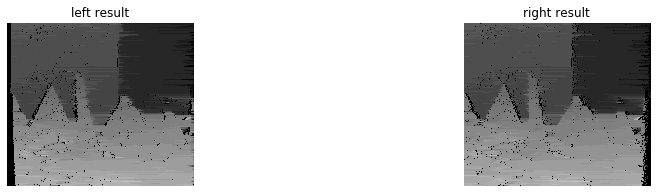

In [12]:
windowSize = 7
dispRange = 30
lamda = 20

st3_left, st3_right = stereo3(img2, img6, dispRange, windowSize, lamda)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st3_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st3_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse(st3_left, st3_right, gt2, gt6)

## Tsukuba

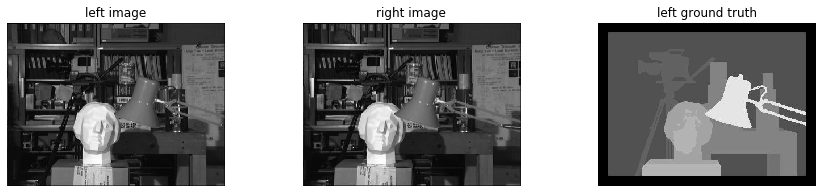

In [13]:
sawtooth2 = "tsukuba/scene1.row3.col3.jpg"
sawtooth6 = "tsukuba/scene1.row3.col5.jpg"

leftGT = 'tsukuba/truedisp.row3.col3.jpg'

# load left, right
left = rgb2gray(plt.imread(sawtooth2)).astype(np.uint8)
right = rgb2gray(plt.imread(sawtooth6)).astype(np.uint8)

# load ground truth
gt = plt.imread(leftGT).astype(np.uint8)

imgs = [left, right, gt]
titles = ['left image', 'right image', 'left ground truth']

# plot images
f, axes = plt.subplots(1, 3, figsize=(15, 3))
for idx, img in enumerate(imgs):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(titles[idx])

### Stereo1

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................MSE_Left Value : 8987.676586009839


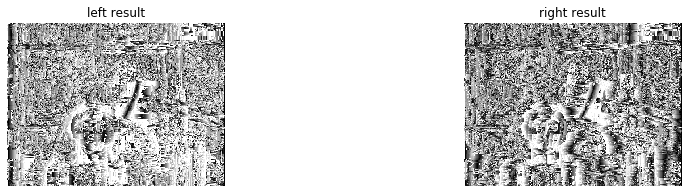

In [14]:
dispRange = 15
st1_left = stereo1(left, right, dispRange)
st1_right = stereo1(right, left, dispRange)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st1_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st1_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse_tsukuba(st1_left, gt)

### Stereo2

(294, 390) (294, 390)
................................................................................................................................................................................................................................................................................................(294, 390) (294, 390)
................................................................................................................................................................................................................................................................................................MSE_Left Value : 12194.176540798611


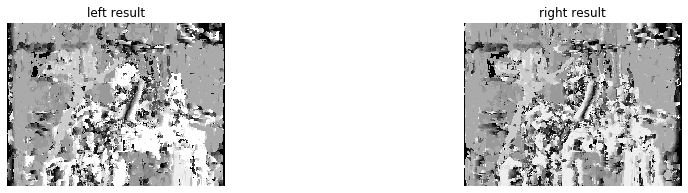

In [15]:
dispRange = 15
windowSize = 7

st2_left = stereo2(left, right, dispRange, windowSize)
st2_right = stereo2(right, left, dispRange, windowSize)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st2_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st2_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse_tsukuba(st2_left, gt)

### Stereo3

MSE_Left Value : 7878.969364872685


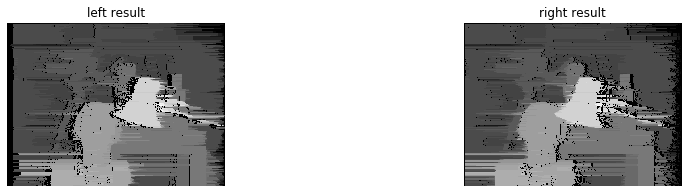

In [16]:
dispRange = 15
windowSize = 7
lamda = 20

st3_left, st3_right = stereo3(left, right, dispRange, windowSize, lamda)

f, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].imshow(st3_left, cmap='gray')
axes[0].axis('off')
axes[0].set_title('left result')

axes[1].imshow(st3_right, cmap='gray')
axes[1].axis('off')
axes[1].set_title('right result')

mse_tsukuba(st3_left, gt)

## Conclusion

In all cases, the stereo2 algorithm performs better.  
#Because, it consider extra smoothness cost